In [2]:
import argparse as ap
from tqdm import tqdm
import numpy as np
import imutils 
import pickle
import time
import cv2
import os

from scipy.cluster.vq import vq, kmeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn import preprocessing
import matplotlib.pyplot as plt


In [4]:
# Todo ...
# Interface to query multiple images
# Modify the result to classification version
# establish a station dataset for classification and evaluation and write a description document.

In [5]:
def data_parse(train_path):
    class_id = 0
    image_paths = []
    image_classes = []
    training_names = os.listdir(train_path)             # 不同类数据采用 label 作为文件夹名称
    for training_name in training_names:                # 遍历每一个类 数据文件夹
        dir = os.path.join(train_path, training_name)
        class_path = imutils.imlist(dir)
        image_paths += class_path
        image_classes += [class_id] * len(class_path)   # 设置标签,用数字替换原始 label,可视化的时候再映射回去
        class_id += 1
    return image_paths, image_classes, training_names

In [6]:
train_path = "/media/ubuntu/zoro/ubuntu/data/train/station/train"
image_paths, image_classes, training_names = data_parse(train_path)
numWords = 100

# 直接把front and side 对应的 图像放入 同一个类别里面训练即可,其他不用改变

### 1, 提取存储orb特征

In [7]:
def extractORB(data_paths):
    des_list = [] 
    orb = cv2.ORB_create()

    for image_path in tqdm(data_paths, desc='Processing'):
        im = cv2.imread(image_path)
        kpts, des  = orb.detectAndCompute(im, None)
        des = des.astype('float32')
        des_list.append((image_path, des))   

    print("Stack all the descriptors vertically in a numpy array ... ")
    descriptors = des_list[0][1]
    for image_path, descriptor in des_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))  
    print("Done!")
    
    return descriptors, des_list

In [8]:
descriptors, des_list = extractORB(image_paths)

Processing: 100%|██████████| 522/522 [00:16<00:00, 30.88it/s]


Stack all the descriptors vertically in a numpy array ... 


### 2, 聚类学习 “视觉词典（visual vocabulary）

In [9]:
def generateVoc(image_paths, descriptors, des_list, numWords, saveVoc_path, image_classes, training_names):
    n = len(image_paths)
    voc, variance = kmeans(descriptors, numWords, 1) # 质心, 平均距离

    # Calculate the histogram of features
    im_features = np.zeros((n, numWords), "float32")
    for i in range(n):
        words, distance = vq(des_list[i][1],voc)
        for w in words:
            im_features[i][w] += 1

    # Perform Tf-Idf vectorization
    nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
    idf = np.array(np.log((1.0*n + 1) / (1.0*nbr_occurences + 1)), 'float32')

    # Perform L2 normalization
    im_features = im_features * idf
    im_features = preprocessing.normalize(im_features, norm='l2')

    # Scaling the words
    stdSlr = StandardScaler().fit(im_features)  # 针对每一个特征维度,计算 均值和方差
    im_features = stdSlr.transform(im_features) # 根据均值和方差计算 标准化

    # Train the Linear SVM
    clf = LinearSVC(max_iter=5000) # max_iter（默认1000）
    clf.fit(im_features, np.array(image_classes))

    with open(saveVoc_path,'wb') as f:
        pickle.dump((clf, training_names, stdSlr, numWords, voc), f)

In [10]:
saveVoc_path = "../vocabulary/vocFusion_cls.pkl"
generateVoc(image_paths, descriptors, des_list, numWords, saveVoc_path, image_classes, training_names)

### 3, classify

In [33]:
def query_SingleImage(image_paths, classes_names, numWords, clf, voc):
    orb = cv2.ORB_create()
    des_list = []
    for image_path in image_paths:
        im = cv2.imread(image_path)
        kpts, des  = orb.detectAndCompute(im, None)
        des = des.astype('float32')
        des_list.append((image_path, des))   

    test_features = np.zeros((len(image_paths), numWords), "float32")
    for i in range(len(image_paths)):
        words, distance = vq(des_list[i][1],voc)
        for w in words:
            test_features[i][w] += 1

    # Perform Tf-Idf vectorization
    nbr_occurences = np.sum( (test_features > 0) * 1, axis = 0)
    idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')
    test_features = test_features * idf
    test_features = preprocessing.normalize(test_features, norm='l2')
    
    # Scale the features
    test_features = stdSlr.transform(test_features)

    # Perform the predictions 
    predictions =  [classes_names[i] for i in clf.predict(test_features)]    
    scores =  [i for i in clf.decision_function(test_features)] # 决策函数, 返回
    # scores =  [np.max(i) for i in clf.decision_function(test_features)]

    return predictions, scores

In [13]:
# todo : image, imageset interface
# evaluation fuction

In [34]:
data = "/media/ubuntu/zoro/ubuntu/data/train/station"
src_image = data + "/test/001801.png"
pkl_path = "../vocabulary/vocFusion_cls.pkl"
clf, classes_names, stdSlr, numWords, voc =  pickle.load(open(pkl_path,'rb'))

In [35]:
start_time = time.time()

predictions, scores = query_SingleImage([src_image], classes_names, numWords, clf, voc)

end_time = time.time()
print("class:{0}, distance: {1:.3f}".format(predictions[0], max(scores[0])))
print("run time: {:.2f}s, FPS:{:.1f}".format(end_time-start_time, 1.0 / (end_time-start_time)))

class:s4, distance: 1.577
run time: 0.03s, FPS:29.1


s4


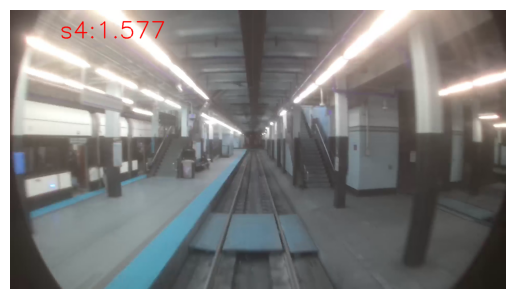

In [36]:
for image_path, prediction, score in zip(image_paths, predictions, scores):
    image = cv2.imread(image_path)
    pt = ( image.shape[1] // 10, image.shape[0] // 10)
    font = cv2.FONT_HERSHEY_SIMPLEX
    print(prediction)
    cv2.putText(image, prediction + ":"+ str(round(max(scores[0]),3)), pt ,font, 3, [255, 0, 0], 3)
    plt.imshow(image)
plt.axis('off')
plt.show()